1. Nettoyage
2. Analyse des variables
3. Encodage (OneHot, LabelEncoder...)
4. Normalisation (et centrage)
5. Split données
6. Fit sur X_train, y_train 
7. Score sur X_test, y_test

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [226]:
df = pd.read_csv('data/data.csv')

# Split des data

In [227]:
y = df['charges']
df = df.drop('charges', axis=1)
X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.85)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', X_train.shape)
print('y_test', X_test.shape)

X_train (1137, 6)
X_test (201, 6)
y_train (1137, 6)
y_test (201, 6)


# Pipeline

In [249]:
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
lab_pipeline = make_pipeline(OrdinalEncoder())

preprocessor = make_column_transformer(
                            (num_pipeline, ['age', 'bmi', 'children']),
                            (cat_pipeline, ['region']),
                            (lab_pipeline, ['sex', 'smoker']),
                            
                        )

set_config(display="diagram")
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'bmi', 'children']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['region']),
                                ('pipeline-3',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['sex', 'smoker'])])

In [256]:
tab = preprocessor.fit(df)
cols = tab.get_feature_names_out()
df_transform = pd.DataFrame(preprocessor.fit_transform(df), columns=cols)
df_transform.head()

,pipeline-1__age,pipeline-1__bmi,pipeline-1__children,pipeline-2__region_northeast,pipeline-2__region_northwest,pipeline-2__region_southeast,pipeline-2__region_southwest,pipeline-3__sex,pipeline-3__smoker
0,-1.438764,-0.453320,-0.908614,0.0,0.0,0.0,1.0,0.0,1.0
1,-1.509965,0.509621,-0.078767,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.797954,0.383307,1.580926,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.441948,-1.305531,-0.908614,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.513149,-0.292556,-0.908614,0.0,1.0,0.0,0.0,1.0,0.0


## Regression linéaire

Score : 0.16146040431208786
MSE : 11299.669061649265


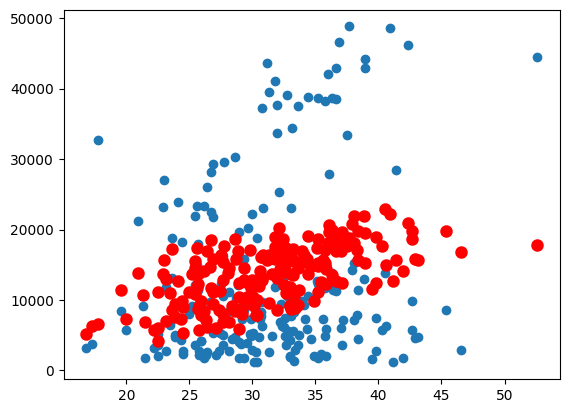

In [230]:
from sklearn.linear_model import LinearRegression

model = make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('MSE :', mse)

plt.scatter(X_test.bmi, y_test)
plt.scatter(X_test.bmi, predictions , c='r', lw=3)

# Elasticnet

In [255]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

alphas = np.linspace(0.1, 1, 20)
l1_ratios = np.linspace(0.01, 1, 20)
model = make_pipeline(preprocessor, PolynomialFeatures(degree=2), ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)) # -> l1_ratio = 1 = Lasso, l1_ratio = 0 = Ridge
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('RMSE :', mse)

# plt.scatter(X_test.bmi, predictions, label='prediction')
# plt.scatter(X_test.bmi, y_test , color='red', label= 'original')
# plt.legend()

Score : 0.857380615823748
RMSE : 4660.078315695484
